# The Sample Data Task



In [0]:
import numpy as np
import scipy.io
import os
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt 
import scipy.stats as stats
import seaborn as sns


## Uploading the sample data csv file to Drive and opening it in Google Colab


In [2]:
folder_id = '1xWCwgDeEHCqeOoKP9xC4XPOD2ueGh62H' 

!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
#    https://developers.google.com/drive/v2/web/search-parameters
file_list = drive.ListFile(
    {'q': '\'' + folder_id + "\' in parents"}).GetList()

for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)
  
os.chdir(local_download_path)

title: sample_data.txt, id: 1DG1vz4aRgyMPWuOkEDhsEwyA5QmXS0_i
downloading to /root/data/sample_data.txt


## Reading the data file

In [0]:
data = pd.read_csv('sample_data.txt') # Reading as a csv file

In [4]:
data.head() # Displaying few values to check what the data is like

,Timestamp,Stream1,Stream2,Stream3,Stream4,Overall,Truth
0,[2016-07-05 20:01:32.470],False,False,False,False,False,False
1,[2016-07-05 20:01:32.580],False,False,False,False,False,False
2,[2016-07-05 20:01:32.727],False,False,False,False,False,False
3,[2016-07-05 20:01:32.837],False,False,False,False,False,False
4,[2016-07-05 20:01:32.947],False,False,False,False,False,False


### Checking the data to see if there are null objects

In [5]:
data.info() # Display information about the data like number of entries, dtype, memory,any empty objects, etc.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8241 entries, 0 to 8240
Data columns (total 7 columns):
Timestamp    8241 non-null object
 Stream1     8241 non-null object
 Stream2     8241 non-null object
 Stream3     8241 non-null object
 Stream4     8241 non-null object
 Overall     8241 non-null object
 Truth       8241 non-null object
dtypes: object(7)
memory usage: 450.8+ KB


### Defining column names

In [0]:
data.columns = ['Timestamp', 'Stream1', 'Stream2', 'Stream3', 'Stream4', 'Overall', 'Truth'] # Setting the columns for the dataframe


### Convert boolean objects to binary


In [0]:
#columns = ['Stream1','Stream2','Stream3','Stream4','Overall','Truth']
for col in data.columns[1:]:
  data[col]= np.where(data[col].str.contains('True'), 1, 0) # Replace True/False with Binary.

### View the modified **data**

In [8]:
data.head()

,Timestamp,Stream1,Stream2,Stream3,Stream4,Overall,Truth
0,[2016-07-05 20:01:32.470],0,0,0,0,0,0
1,[2016-07-05 20:01:32.580],0,0,0,0,0,0
2,[2016-07-05 20:01:32.727],0,0,0,0,0,0
3,[2016-07-05 20:01:32.837],0,0,0,0,0,0
4,[2016-07-05 20:01:32.947],0,0,0,0,0,0


## Seeing that it's a time-series data, import the data as a time-series dataframe

In [0]:
dateparse = lambda dates: pd.datetime.strptime(dates, '[%Y-%m-%d %H:%M:%S.%f]')  # Parse dates in a particular format defined in the data
data_ts = pd.read_csv('sample_data.txt', parse_dates=['Timestamp'], index_col='Timestamp', date_parser=dateparse) # Read as a timeseries dataframe


### Let's view the time-series dataframe

In [10]:
data_ts.head()

,Stream1,Stream2,Stream3,Stream4,Overall,Truth
Timestamp,,,,,,
2016-07-05 20:01:32.470,False,False,False,False,False,False
2016-07-05 20:01:32.580,False,False,False,False,False,False
2016-07-05 20:01:32.727,False,False,False,False,False,False
2016-07-05 20:01:32.837,False,False,False,False,False,False
2016-07-05 20:01:32.947,False,False,False,False,False,False


### Define column names and convert boolean objects to binary

In [0]:
data_ts.columns = ['Stream1', 'Stream2', 'Stream3', 'Stream4', 'Overall', 'Truth']
#columns = ['Stream1','Stream2','Stream3','Stream4','Overall','Truth']
for col in data_ts.columns:
  data_ts[col] = np.where(data_ts[col].str.contains('True'), 1, 0) # Replace True/False with Binary.

### Let's view the modified time-series dataframe

In [12]:
data_ts.head()

,Stream1,Stream2,Stream3,Stream4,Overall,Truth
Timestamp,,,,,,
2016-07-05 20:01:32.470,0,0,0,0,0,0
2016-07-05 20:01:32.580,0,0,0,0,0,0
2016-07-05 20:01:32.727,0,0,0,0,0,0
2016-07-05 20:01:32.837,0,0,0,0,0,0
2016-07-05 20:01:32.947,0,0,0,0,0,0


#Data Analysis
SInce the objective is to use the data from the node streams to somehow figure out if a person is present or not, I thought it would make more sense to club the time-stamps in intervals, and see what happens.
Now, within each interval, if there are more number of 'True's than 'False's for a Node's stream, it is reasonable to say that the Node stream value for that interval will be True, and vice-versa.
In Statistics, it's nothing but the mode in the interval for each Node Stream.


## Assumption 1: 

1) All Nodes are working fine

2) There is no blindspot where all the Node Streams cannot reach.

### Case 1: I am going to resample (group/ take intervals) for every 1 minute. 
This also helps to consider the temporal characteristics in a minute, as in a minute, the number (1 or 0) which occurs the most should reflect the output for the minute.

In [13]:
data_ts_1min=data_ts.resample('1min').apply(lambda x: stats.mode(x)[0]) # The Time-series Dataframe sampled every 1 minute, and in that minute, mode of each Node streams are taken.
data_ts_1min



,Stream1,Stream2,Stream3,Stream4,Overall,Truth
Timestamp,,,,,,
2016-07-05 20:01:00,0,0,0,0,0,0
2016-07-05 20:02:00,0,1,0,0,1,1
2016-07-05 20:03:00,1,1,0,0,1,1
2016-07-05 20:04:00,1,0,0,0,1,1
2016-07-05 20:05:00,0,0,0,0,1,1
2016-07-05 20:06:00,0,0,0,1,1,1
2016-07-05 20:07:00,0,0,0,1,1,1
2016-07-05 20:08:00,0,0,0,0,0,0
2016-07-05 20:09:00,0,0,0,0,0,0


#### Let's plot the data from each Node stream taken every 1 minute and analyse it

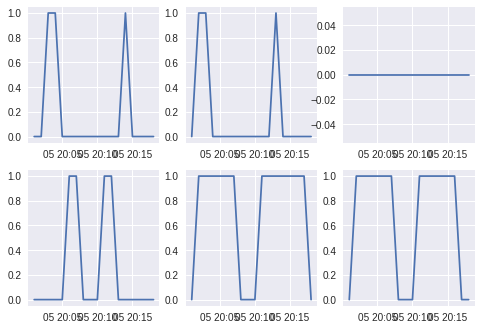

In [14]:
for i,j in enumerate(data_ts.columns,1):
  plt.subplot(2,3,i)
  df = data_ts_1min[j]
  plt.plot(df)

#### Let's make the plots little better shall we?


Text(0.5, 0.95, 'Plot of Node Streams(1-4) vs Time-Frame sampled at 1 minute')

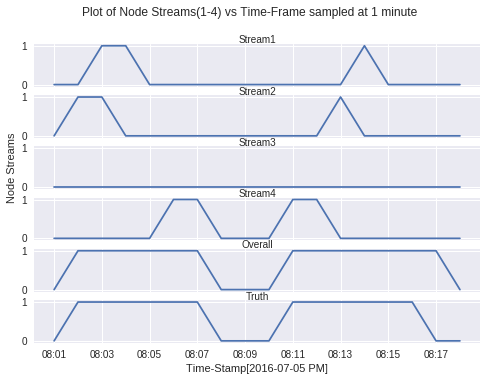

In [15]:
fig, ax = plt.subplots(6, 1, sharex=True, sharey=True)
data_ts_1min.index= data_ts_1min.index.strftime("%I:%M") # Since we know the Date to be the same, so just the time is plotted.
for i,j in enumerate(data_ts.columns,1):
  df = data_ts_1min[j]
  ax[i-1].plot(df)
  ax[i-1].set_title(data_ts.columns[i-1], fontsize=10, pad=0.5)
  if i==3:
    ax[i-1].set(ylabel='Node Streams')
  if i==6:
    ax[i-1].set(xlabel='Time-Stamp[2016-07-05 PM]')
#ax.xlabel('Time-Stamp (PM)')
for axi in ax.flat:
    axi.xaxis.set_major_locator(plt.MaxNLocator(10)) # Controls number of ticks at the axes. Here 10 is fine along the x-axis.
    #axi.yaxis.set_major_locator(plt.MaxNLocator(2))

caption="Plot of Node Streams(1-4) vs Time-Frame sampled at 1 minute"
fig.text(.5, 0.95, caption, ha='center')


#### What do we see?
In the time-interval 8:01-8:18pm,
1. Stream1 : Between 8:03-8:04pm and at 8:14pm, Node1 detects something.
2. Stream2:  Between 8:02-8:03pm and at 8:13pm, Node2 detects something.
3. Stream3:  Node2 doesn't detect anything,
4. Stream4:  Between 8:05pm-8:07pm and between 8:11-8:12pm, Node4 detects something
5. Overall BlackBox: This takes in Stream1-4, and through some logic (unknown at this point), tells that, between 8:02-8:07pm and between 8:11-8:17pm, something was detected.
6. Truth: This gives us the truth behind if something is present in the room or not. From the graph, the Truth says that there is a person between 8:02-8:07pm and between 8:11-8:16pm.

### Case 2: Now I am going to resample for every 2 minutes, and see what happens

In [16]:
data_ts_2min = data_ts.resample('2min').apply(lambda x: stats.mode(x)[0]) # The Time-series Dataframe sampled every 2 minute, and within those 2 minutes, mode of each Node streams are taken.
data_ts_2min

,Stream1,Stream2,Stream3,Stream4,Overall,Truth
Timestamp,,,,,,
2016-07-05 20:00:00,0,0,0,0,0,0
2016-07-05 20:02:00,1,1,0,0,1,1
2016-07-05 20:04:00,1,0,0,0,1,1
2016-07-05 20:06:00,0,0,0,1,1,1
2016-07-05 20:08:00,0,0,0,0,0,0
2016-07-05 20:10:00,0,0,0,0,0,0
2016-07-05 20:12:00,0,0,0,0,1,1
2016-07-05 20:14:00,0,0,0,0,1,1
2016-07-05 20:16:00,0,0,0,0,1,1


#### Let's plot the data from each Node stream again but for every 2 minutes and analyse it

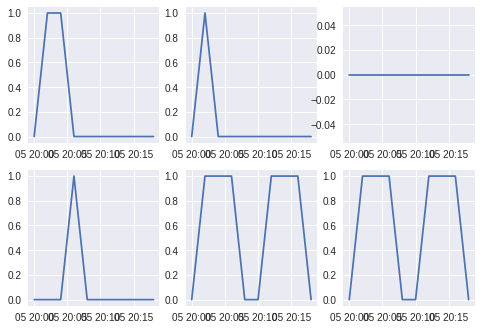

In [17]:
for i,j in enumerate(data_ts.columns,1):
  plt.subplot(2,3,i)
  df = data_ts_2min[j]
  plt.plot(df)

#### Let's again make the plots little better shall we?


Text(0.5, 0.95, 'Plot of Node Streams(1-4) vs Time-Frame sampled at 2 minutes')

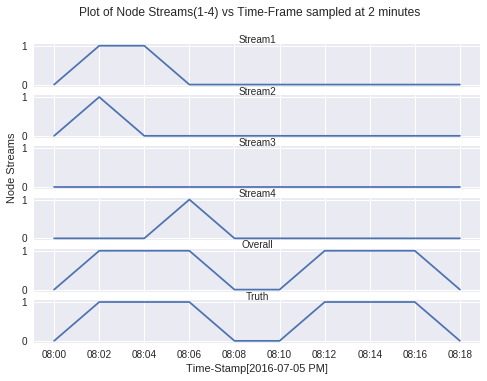

In [18]:
fig, ax = plt.subplots(6, 1, sharex=True, sharey=True)
data_ts_2min.index= data_ts_2min.index.strftime("%I:%M") # We just use time once again.
for i,j in enumerate(data_ts.columns,1):
  df = data_ts_2min[j]
  ax[i-1].plot(df)
  ax[i-1].set_title(data_ts.columns[i-1], fontsize=10, pad=0.5)
  if i==3:
    ax[i-1].set(ylabel='Node Streams')
  if i==6:
    ax[i-1].set(xlabel='Time-Stamp[2016-07-05 PM]')

for axi in ax.flat:
    axi.xaxis.set_major_locator(plt.MaxNLocator(10))
    #axi.yaxis.set_major_locator(plt.MaxNLocator(2))
    
caption="Plot of Node Streams(1-4) vs Time-Frame sampled at 2 minutes"
fig.text(.5, 0.95, caption, ha='center')


#### What do we see?
In the time-interval 8:01-8:18pm,
1. Stream1 : Between 8:02-8:04pm, Node1 detects something.
2. Stream2:  Between 8:02-8:03pm and at 8:13pm, Node2 detects something.
3. Stream3:  Node2 doesn't detect anything,
4. Stream4:  Between 8:05pm-8:07pm and between 8:11-8:12pm, Node4 detects something
5. Overall BlackBox: This takes in Stream1-4, and through some logic (unknown at this point), tells that, between 8:02-8:07pm and between 8:11-8:17pm, something was detected.
6. Truth: This gives us the truth behind if something is present in the room or not. From the graph, the Truth says that there is a person between 8:02-8:07pm and between 8:11-8:16pm.

When we compare the data sampled every 1 minute to that sampled every 2 minutes, the major difference is that there will be a loss in information as we increase our sample interval. Just want to keep tabs whether that loss in information would probably be more/less influenced in the black-box decision. It's a tradeoff between accuracy and speed which we have to keep in mind as well.

###Let's try to figure out an algorithm which somewhat depicts the 'Truth'.

In [0]:
def OR(a,b): # OR-Gate logic. Returns HIGH if atleast one of the inputs is HIGH, otherwise returns LOW.
  output = np.logical_or(a, b).astype(int)
  return output


#### Each Stream outputs (from 1-4), are succesively 'OR gated' with each other, and that output is compared with the expected Overall and Truth columns.
####Logic?
If atleast one of the Node Streams have detected something, the output from the Overall blackbox should be 1. If none of the streams have detected anything, then surely, the blackbox should return a 0.

This is a very simple and naive approach, but looking at the pattern, it does look like it would be enough to mimic the Truth values.

The Assumption is that:
1. All the Nodes are working fine.
2. None of the nodes are tripped only due to person detection and nothing else.

####Case1: This is done first for the 1minute resampled data.

Text(0.5, 0.92, 'Plot of Overall,Truth and Proposed Model Outputs vs Time-Frame sampled at 1 minute')

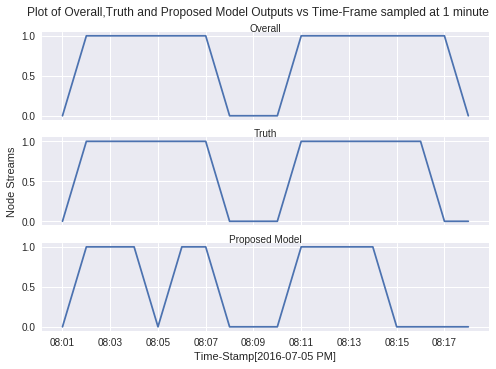

In [20]:
df = OR(data_ts_1min[data_ts.columns[0]],data_ts_1min[data_ts.columns[1]])
for i in range(1,3):
  #print(columns[i+1])
  df = OR(df,data_ts_1min[data_ts.columns[i+1]]) # Stream1-4 are consecutively OR-ed with each other. So, if atleast one of the Node-streams returns 1, the Output should be a 1, otherwise a 0

fig, ax = plt.subplots(3, 1, sharex=True, sharey=True) # Plotting the Output of the proposed algorithm ('Perceived Algorithm') versus the 'Overall' and the 'Truth' columns
#print(df.index)
#df.index= df.index.strftime("%I:%M")
ax[0].plot(data_ts_1min['Overall'])
ax[1].plot(data_ts_1min['Truth'])
ax[2].plot(df)

columns_new = ['Overall','Truth','Proposed Model']
for i in range(3):
  ax[i].set_title(columns_new[i], fontsize=10, pad=0.5)
  if i==1:
    ax[i].set(ylabel='Node Streams')
  if i==2:
    ax[i].set(xlabel='Time-Stamp[2016-07-05 PM]')


for axi in ax.flat:
    axi.xaxis.set_major_locator(plt.MaxNLocator(10))
    #axi.yaxis.set_major_locator(plt.MaxNLocator(2))  
    
caption="Plot of Overall,Truth and Proposed Model Outputs vs Time-Frame sampled at 1 minute"
fig.text(.5, 0.92, caption, ha='center')



#### We can analyse from the graph how similar the Perceived Algorithm of the Overall Blackbox is with the original 'Overall' and 'Truth' values. 
Somewhat similar right?
It's same from 8:01-8:04pm, 8:05-8:14pm and 8:17pm-8:18pm (Comparing with the Truth values)  
#### Let's prove it analytically though. Let's find the correlation between each of them with one another and see.


In [21]:
print(df.corr(data_ts_1min['Overall'])) # Correlation between Perceived Output and Overall
print(df.corr(data_ts_1min['Truth'])) # Correlation between Perceived Output and Truth
print(data_ts_1min['Overall'].corr(data_ts_1min['Truth'])) # Correlation between Overall and Truth

0.6201736729460422
0.7071067811865474
0.8770580193070291


We see that the Perceived Algorithm is 62% correlated with the expected Overall column of the Blackbox, and is  70.7% correlated with that of the Truth, which isn't that bad, but could be better as the Overall and the Truth are 87.7% correlated, which is what we want to aim for and/or beat.

In [22]:
data_ts_1min['Proposed Model']=df
data_ts_1min # The Perceived Model column added to the original dataframe for comparision.

,Stream1,Stream2,Stream3,Stream4,Overall,Truth,Proposed Model
08:01,0,0,0,0,0,0,0
08:02,0,1,0,0,1,1,1
08:03,1,1,0,0,1,1,1
08:04,1,0,0,0,1,1,1
08:05,0,0,0,0,1,1,0
08:06,0,0,0,1,1,1,1
08:07,0,0,0,1,1,1,1
08:08,0,0,0,0,0,0,0
08:09,0,0,0,0,0,0,0
08:10,0,0,0,0,0,0,0


####Case2: Now we do it for the 2minute resampled data.


Text(0.5, 0.92, 'Plot of Overall,Truth and Proposed Model Outputs vs Time-Frame sampled at 2 minutes')

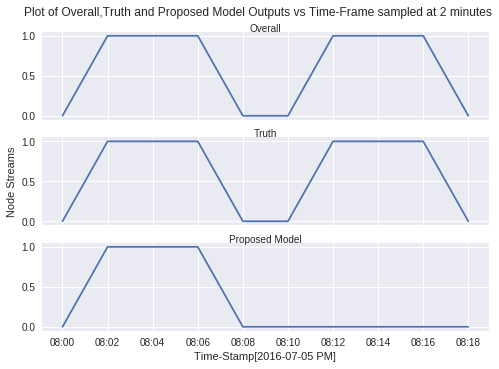

In [23]:
df2 = OR(data_ts_2min[data_ts.columns[0]],data_ts_2min[data_ts.columns[1]]) # We do the same process as the 1 minute sampled datam with the 2 minute sampled data.
for i in range(1,3):
  df2 = OR(df2,data_ts_2min[data_ts.columns[i+1]]) # Stream1-4 consecutively OR-ed with each other. 
fig, ax = plt.subplots(3, 1, sharex=True, sharey=True) # Plotting the plots
#print(df.index)
#df.index= df.index.strftime("%I:%M")

ax[0].plot(data_ts_2min['Overall'])
ax[1].plot(data_ts_2min['Truth'])
ax[2].plot(df2)

for i in range(3):
  ax[i].set_title(columns_new[i], fontsize=10, pad=0.5)
  if i==1:
    ax[i].set(ylabel='Node Streams')
  if i==2:
    ax[i].set(xlabel='Time-Stamp[2016-07-05 PM]')


for axi in ax.flat:
    axi.xaxis.set_major_locator(plt.MaxNLocator(10))
    #axi.yaxis.set_major_locator(plt.MaxNLocator(2))  

caption="Plot of Overall,Truth and Proposed Model Outputs vs Time-Frame sampled at 2 minutes"
fig.text(.5, 0.92, caption, ha='center')

#### Now we analyse from the graph how similar the Perceived Algorithm of the Overall Blackbox is with the original 'Overall' and 'Truth' values for the data taken every 2minutes. 
Not similar after 8:08pm right?
#### Let's prove it analytically again through finding the correlation between each of them with one another and see.


In [24]:
print(df2.corr(data_ts_2min['Overall'])) # Correlation between Perceived Output and Overall
print(df2.corr(data_ts_2min['Truth'])) # Correlation between Perceived Output and Truth
print(data_ts_2min['Overall'].corr(data_ts_2min['Truth'])) # Correlation between Overall and Truth

0.5345224838248486
0.5345224838248486
1.0


We see that the Perceived Algorithm is 53.5% correlated with both, the expected Overall column of the Blackbox, and that of the Truth, which is pretty bad.
The correlation between the Overall and the Truth column is 100%, which means, at 2minute intervals, the Overall and the Truth matrix matches-up perfectly, while our expected algorithm performed badly.

#### Result
We see that the Proposed Model for the 1 minute sampled data does slightly better than the 2 minute sampled data. Clearly loss of information does play a vital role here.

In the next section, we critically analyse further and see where actually our proposed algorithm fails.

In [25]:
data_ts_2min['Proposed Model']=df2
data_ts_2min

,Stream1,Stream2,Stream3,Stream4,Overall,Truth,Proposed Model
08:00,0,0,0,0,0,0,0
08:02,1,1,0,0,1,1,1
08:04,1,0,0,0,1,1,1
08:06,0,0,0,1,1,1,1
08:08,0,0,0,0,0,0,0
08:10,0,0,0,0,0,0,0
08:12,0,0,0,0,1,1,0
08:14,0,0,0,0,1,1,0
08:16,0,0,0,0,1,1,0
08:18,0,0,0,0,0,0,0


### So what's wrong? Why is it that the proposed model isn't close to the Overall/Truth?
#### Let's do some analysis here
If we look at the data from that sampled every minute, we can see at 8:05pm and from 8:14-8:17pm, the model gave an output as 0, which means it didn't detect anyone, while the 'Truth' column, detected a person in the above intervals.
Let's see the Proposed model along with the Truth data at these intervals to make better sense.

In [26]:
dft1 = data_ts_1min.loc["08:05":"08:06"]
dft2 = data_ts_1min.loc["08:15":"08:16"]
dft = pd.concat([dft1,dft2])
dft = dft.drop(["08:06"])
dft


,Stream1,Stream2,Stream3,Stream4,Overall,Truth,Proposed Model
08:05,0,0,0,0,1,1,0
08:15,0,0,0,0,1,1,0
08:16,0,0,0,0,1,1,0


So, what do we notice here? We see that, even if all the Streams are returning False, ie, not detected any person present, the Truth is that someone is.

My model functions in the basic logic that, if atleast one of any of the Node's streams is True, ie, it detects something, the whole system should return a True. However, in the above cases, since none of the Nodes are detecting anything, my model would logically return a 0.

####This begs the question, why does the Truth column say that there actually is a person present, eventhough none of the Nodes say there is?

I can think of 2 possible reasons:

####1. There is a blind-spot where all the Nodes cannot reach, and the person is right at that point. 
####2. (And I think it's most likely)  Node2 isn't functioning properly.

Let's discuss the 2nd point.

I came to this decision, because, if we see the plots, Node2's stream returned a False everytime during the whole time-interval of the data.

Now, when the Truth does mention that a person is detected, and none of the Nodes are returning True for the case, and we have a Node stream that has been return False throughout the time-frame, it wouldn't be a wrong assumption to conclude that the Node, which is Node2, is faulty and acting wierd. 

So, we are going to violate our Assumption 1. where we assumed all the Nodes to be functioning properly, and with good reasoning, say that all except Node2 (Stream3) function properly.

In [27]:
# Proof that Node2 (Stream3) is returning False everytime. Let's look at the Original time-series dataframe and see if anywhere Stream3 returns True.
data_ts[data_ts['Stream3']==1]

,Stream1,Stream2,Stream3,Stream4,Overall,Truth
Timestamp,,,,,,


#### We see from above that in-fact Node2 returns False for the whole interval, which lead me to believe Node2 could be faulty.

## Assumption 2: 

1) Node2 (Stream3) is faulty while other Nodes are working fine. So, let's see a case if Node2 weren't faulty, ie, at the time-stamps where all the Node streams return False, but the 'Truth' actually returns a True, which leads to believe, provided there are no blindspots, that atleast one of the Nodes have to be True, so I will just make Node2 True in these cases and see what happens.

2) There is no blindspot where all the Node Streams cannot reach.

### Let's do something interesting. 
####For the sake of argument, let's make all the Stream3 values from Node2 True when all other Node Streams are False and the Truth is True.

In [28]:
#data_ts_1min
data_ts_1min['Stream3'].loc[(data_ts_1min['Stream1'] == 0) & (data_ts_1min['Stream2'] == 0) & (data_ts_1min['Stream3'] == 0) & (data_ts_1min['Stream4'] == 0) & (data_ts_1min['Truth'] == 1)]=1
data_ts_1min.loc[(data_ts_1min['Stream1'] == 0) & (data_ts_1min['Stream2'] == 0) & (data_ts_1min['Stream3'] == 0) & (data_ts_1min['Stream4'] == 0) & (data_ts_1min['Truth'] == 1)]
data_ts_1min.iloc[:,:-1]

,Stream1,Stream2,Stream3,Stream4,Overall,Truth
08:01,0,0,0,0,0,0
08:02,0,1,0,0,1,1
08:03,1,1,0,0,1,1
08:04,1,0,0,0,1,1
08:05,0,0,1,0,1,1
08:06,0,0,0,1,1,1
08:07,0,0,0,1,1,1
08:08,0,0,0,0,0,0
08:09,0,0,0,0,0,0
08:10,0,0,0,0,0,0


#### We can see that the Stream3 values when the Truth is 1 and when all the Node streams are 0 has changed to 1.
Now, with this modified dataframe, we apply our Proposed Model and see the correlation.

### Let's find the Proposed Model to this new table.

Text(0.5, 0.92, 'Plot of Overall,Truth and Proposed Model Outputs vs Time-Frame sampled at 1 minute')

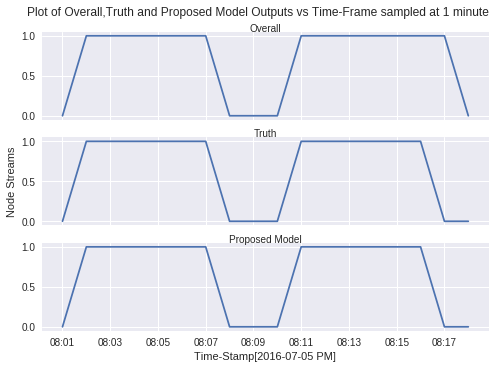

In [29]:
df3 = OR(data_ts_1min[data_ts.columns[0]],data_ts_1min[data_ts.columns[1]])
for i in range(1,3):
  df3 = OR(df3,data_ts_1min[data_ts.columns[i+1]])

fig, ax = plt.subplots(3, 1, sharex=True, sharey=True)
#print(df.index)
#df.index= df.index.strftime("%I:%M")
ax[0].plot(data_ts_1min['Overall'])
ax[1].plot(data_ts_1min['Truth'])
ax[2].plot(df3)

for i in range(3):
  ax[i].set_title(columns_new[i], fontsize=10, pad=0.5)
  if i==1:
    ax[i].set(ylabel='Node Streams')
  if i==2:
    ax[i].set(xlabel='Time-Stamp[2016-07-05 PM]')


for axi in ax.flat:
    axi.xaxis.set_major_locator(plt.MaxNLocator(10))
    #axi.yaxis.set_major_locator(plt.MaxNLocator(2))  

caption="Plot of Overall,Truth and Proposed Model Outputs vs Time-Frame sampled at 1 minute"
fig.text(.5, 0.92, caption, ha='center') 


In [30]:
data_ts_1min['Proposed Model(After Modification)']=df3 # Where 'After Modification' means that assuming Node2 is faulty, so wherever the Truth value is 1 
                                                        #when all Node Streams are 0, I changed Node2(Stream3) to 1.
# This is just to confirm my Hypothesis, that if Node2 was indeed faulty(which seems likely), and if it weren't, the Proposed algorithm should perform well.  
data_ts_1min


,Stream1,Stream2,Stream3,Stream4,Overall,Truth,Proposed Model,Proposed Model(After Modification)
08:01,0,0,0,0,0,0,0,0
08:02,0,1,0,0,1,1,1,1
08:03,1,1,0,0,1,1,1,1
08:04,1,0,0,0,1,1,1,1
08:05,0,0,1,0,1,1,0,1
08:06,0,0,0,1,1,1,1,1
08:07,0,0,0,1,1,1,1,1
08:08,0,0,0,0,0,0,0,0
08:09,0,0,0,0,0,0,0,0
08:10,0,0,0,0,0,0,0,0


#### Now we analyse from the graph how similar the Proposed Algorithm of the Overall Blackbox is with the original 'Overall' and 'Truth' values for the data. 
Similar right?
#### Let's prove it analytically again through finding the correlation between each of them with one another and see.


In [31]:
print(df3.corr(data_ts_1min['Overall'])) # Correlation between Perceived Output and Overall
print(df3.corr(data_ts_1min['Truth'])) # Correlation between Perceived Output and Truth
print(data_ts_1min['Overall'].corr(data_ts_1min['Truth'])) # Correlation between Overall and Truth

0.877058019307029
0.9999999999999999
0.8770580193070291


We see that the Proposed Algorithm is 87.7% correlated with the expected Overall column of the Blackbox, and 99.9% with that of the Truth, which is pretty good.
The correlation between the Overall and the Truth column is 87.7%.


### What does this Prove?
The above results prove that, if Node2 worked as it should have, the Perceived proposed algorithm would have worked very well.

Now, this is under the assumption that, Node2 is faulty. But of-course, if Node2 wasn't faulty, and there was some other reason why, even if all the Nodes gave a False, the Truth did say that there was a person present, then the proposed algorithm wouldn't perform this well.
Once again, it just didn't make sense to me that the Truth return 1 when all Streams were 0, and so it is a resonable assumption that Node2 could be faulty.



### Just to check, keeping the above assumption that Node2 is defected and the changes that Node2 stream's values should be 1 when all others' are 0 and Truth is 1,  let's do that for the entire data, instead of the sampled version of 1minute, and see what results we get.

In [0]:
#Original Data
data_orig = data_ts.copy(deep=True)
data_orig['Stream3'].loc[(data_orig['Stream1'] == 0) & (data_orig['Stream2'] == 0) & (data_orig['Stream3'] == 0) & (data_orig['Stream4'] == 0) & (data_orig['Truth'] == 1)]=1


#### Performing the OR  operation between columns to get the Perceived Model

Text(0.5, 0.92, 'Plot of Overall,Truth and Proposed Model Outputs vs Time-Frame for the Original data')

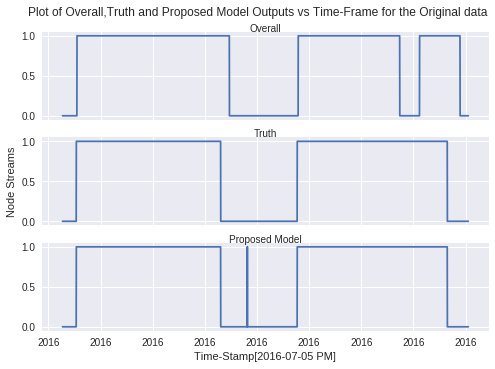

In [33]:
df4 = OR(data_orig[data_ts.columns[0]],data_orig[data_ts.columns[1]])
for i in range(1,3):
  #print(columns[i+1])
  df4 = OR(df4,data_orig[data_ts.columns[i+1]])
  
fig, ax = plt.subplots(3, 1, sharex=True, sharey=True)
#print(df.index)
#df4.index= df4.index.strftime("%I:%M")

ax[0].plot(data_orig['Overall'])
ax[1].plot(data_orig['Truth'])
ax[2].plot(df4)

for i in range(3):
  ax[i].set_title(columns_new[i], fontsize=10, pad=0.5)
  if i==1:
    ax[i].set(ylabel='Node Streams')
  if i==2:
    ax[i].set(xlabel='Time-Stamp[2016-07-05 PM]')


for axi in ax.flat:
    axi.xaxis.set_major_locator(plt.MaxNLocator(10))
    #axi.yaxis.set_major_locator(plt.MaxNLocator(2))  

caption="Plot of Overall,Truth and Proposed Model Outputs vs Time-Frame for the Original data"
fig.text(.5, 0.92, caption, ha='center')

#### Analysising the output of the Perceived Model with the Overall and Truth columns by correlation.

In [34]:
print(df4.corr(data_orig['Overall'])) # Correlation between Perceived Output and Overall
print(df4.corr(data_orig['Truth'])) # Correlation between Perceived Output and Truth
print(data_orig['Overall'].corr(data_orig['Truth'])) # Correlation between Overall and Truth

0.7336457659987079
0.9996953351888149
0.7339871377021754


#### We see we get a correlation of 99.9% with the Truth , better than that between the Overall and the Truth.

So, this again proves that the assumption that Node2 is faulty could be right.

## Assumption 3: 

1) All Nodes are working fine.

2) There is in-fact a blindspot where all the Node Streams cannot reach, so we will create a new column called 'Blindspot Stream', which will return 1 when other Nodes return 0 , when the Truth says it's actually 1.

#### What's the purpose?
Maybe from this, can we zone-in the location where the blindspot could be? Let's analyse and see.

In [0]:
# For this assumption, because we want to possibly zone-in on the blindspot, we are going to take the original dataframe, without sampling for 1minute/2minutes.
data_original = data_ts.copy(deep=True)
data_original.index= data_original.index.strftime("%I:%M:%S:%f")


#### Strategy.

In-order to fine the regions where the possible blind-spot is, 

1) Find the time-stamps where all Streams return 0, and Truth is 1.

2) For each of the time-stamp, find the Node-stream which was True Before and After the interval when all the Streams are 0 and Truth is 1.

3) The above idea will help us figure out where the person is before and after the time-intervals when the Node Streams couldn't detect the person when in-fact he/she was there.

In [36]:
data_new = data_original.drop(['Overall'], axis=1)
data_sum = data_new.sum(axis=1) # Sum all columns, except 'Overall'. # 'Blindspot Interval': The interval where are Nodes returns 0 but the Truth returns 1.
before = data_sum[(data_sum>1) & (data_sum.shift(-1)==1)] # Data where the below time-stamp has output of 1 and the current>1. This is the time just before the 'blindspotted' interval 
#b_curr = data_sum[(data_sum==1) & (data_sum.shift()>1)]
after = data_sum[(data_sum>1) & (data_sum.shift()==1)] # Data where the above time-stamp has output of 1 and the current>1. This is the time just after the 'blindspotted' interval
#a_curr = data_sum[(data_sum==1) & (data_sum.shift(-1)>1)]
  
combo = pd.concat([before[:-1],after[1:]], axis=1) # Concatenate the time-stamps Before and After the blindspotted interval
y = data_new.loc[combo.index] # Locate those indices in the original data
before[:-1] # The time-stamps just before the 'Blindspotted interval'

08:02:15:945000    2
08:02:20:502000    2
08:05:13:673000    2
08:05:25:398000    2
08:07:40:173000    2
08:11:18:613000    2
08:11:19:348000    2
08:12:35:898000    2
08:14:30:785000    2
08:14:33:137000    2
08:16:27:171000    2
08:16:31:324000    2
dtype: int64

In [37]:
after[1:]# The time-stamps just after the 'Blindspotted interval'

08:02:16:459000    2
08:02:21:972000    2
08:05:22:722000    2
08:05:49:026000    2
08:11:18:356000    2
08:11:18:981000    2
08:11:19:826000    2
08:13:21:100000    2
08:14:32:770000    2
08:16:22:504000    2
08:16:29:009000    2
08:17:22:635000    2
dtype: int64

In [0]:
y = y.drop(['Truth'],axis=1) # Remove the Truth column, so that only the Node Streams remain

#### Analysis of the above table
What does the table depict?



In [39]:
y2 = y.dot(y.columns) # Finding the node-streams which are 1 in each time-stamp
y2

08:02:15:945000    Stream2
08:02:16:459000    Stream2
08:02:20:502000    Stream2
08:02:21:972000    Stream2
08:05:13:673000    Stream1
08:05:22:722000    Stream1
08:05:25:398000    Stream1
08:05:49:026000    Stream4
08:07:40:173000    Stream4
08:11:18:356000    Stream4
08:11:18:613000    Stream4
08:11:18:981000    Stream4
08:11:19:348000    Stream4
08:11:19:826000    Stream4
08:12:35:898000    Stream4
08:13:21:100000    Stream2
08:14:30:785000    Stream1
08:14:32:770000    Stream1
08:14:33:137000    Stream1
08:16:22:504000    Stream4
08:16:27:171000    Stream4
08:16:29:009000    Stream4
08:16:31:324000    Stream4
08:17:22:635000    Stream2
dtype: object

The above dataframe contains the time-stamps just Before and just After those when all Node-Streams are 0 while the Truth is 1.
So, as we go alternately, we go like Before,After,Before,After,and so on.

#### For Example:

Let;s take the first two time-stamps: 08:02:15:945000  and 08:02:16:459000, and let's see Node Streams of the time-stamps that occur in-between and including the two.



In [40]:
data_original['08:02:15:945000':'08:02:16:459000']

,Stream1,Stream2,Stream3,Stream4,Overall,Truth
08:02:15:945000,0,1,0,0,1,1
08:02:16:092000,0,0,0,0,1,1
08:02:16:202000,0,0,0,0,1,1
08:02:16:312000,0,0,0,0,1,1
08:02:16:459000,0,1,0,0,1,1


#### Let's inspect the above dataframe carefully.
1) At 08:02:15:945000	: We see that the Person is detected by Node1 (Stream2).

2) From 08:02:16:092000 to 08:02:16:312000, all the Node Streams return a 0, when clearly the Truth returns a 1, which means none of the Nodes are detecting the person when in-actuality the person is present.

3) At 08:02:16:459000, the person is again detected by Node1(Stream2).

#### So, what does this mean?
1) Before 08:02:16:092000 to 08:02:16:312000, where the person isn't at-all detected, the person is spotted at Node1. Then after 08:02:16:312000, the person is spotted back at Node1.
So, somewhere, there is a blindspot which exists around Node1, and at a strategic point such that even the other Nodes can't detect.

2) This is what I am trying to find. The 'Before' and 'After' the time-stamp interval where the person is no longer getting detected when in-fact the person is present.

3) The logic is that, if we see all these Before and After timestamps, we can form a rough idea where the Blind-spot can be located, so that, if we did place another node at that point, it can further bring the proposed algorithm closer to the Truth's.

In [41]:
# Table to better depict y2. Here, index refers to the blindspotted time-intervals where all Node streams are 0 while Truth is 1
columns = ['Before','After']
index = range(0,12)
df_ = pd.DataFrame(index=index, columns=columns)
df_['Before']= y2.values[::2]
df_['After']= y2.values[1::2]
df_

,Before,After
0,Stream2,Stream2
1,Stream2,Stream2
2,Stream1,Stream1
3,Stream1,Stream4
4,Stream4,Stream4
5,Stream4,Stream4
6,Stream4,Stream4
7,Stream4,Stream2
8,Stream1,Stream1
9,Stream1,Stream4


Since now my goal is understood, let's look at the above data.

Below, the terminology, 'interval' means the time-interval when all the NodeStreams don't detect a person, ie, return a 0 , but the Truth returns a 1, ie, a person is present.

We see that, for various 'intervals' , the person before that 'interval', and after that 'interval', was seen around different Nodes.

1) It's starts off with the Person first at Node1 (Stream2), then the 'interval' happened (time when all nodes didn't detect anything but Truth was 1), then seen again at Node1.

2) Then at 08:02:20:502000, the person is spotted at Node1 only, and after the 'interval', spotted at the same place at 08:02:21:972000  .

3) Then at 08:05:13:673000, the person is spotted at Node0 , and after the 'interval', spotted at the same place at 08:05:22:722000  .

4) Then at 08:05:25:398000, the person is detected at Node0, but after the 'interval' spotted at Node3 at 08:05:49:026000.

Like that, we see that the person is detected at a single Node (except Node2) before the 'interval', and spotted after the 'interval' at either the same/different Node (except for Node2), which leads to believe the following:
#### The Blindspot is at the center of the room.
####Why?
Since during the Before and After time-stamps of the 'interval', only one of the Nodes, not more than 1 Node detects the person, so, intuitively, the blindpsot has to be at the center of the room in-order for the above table to make sense.

#### Conclusion?
If there were an additional Node placed at the center of the room, it would the person, and the Proposed algorithm of ORing between Node-streams would work very well, in-fact it will be the exact same correlation results as obtained in Assumpion2 (where it was assumed that if there wasn't a blindspot, and Node2 was functioning properly, so during the 'intervals', logically Node2 (Stream3) should return a True when all others don't detect anything, when in-fact the person is actually present)

So, if the Assumption is that all the Nodes arew working just fine, thus there is indeed a blinspot, and that blindspot is located at the center, so if another node is present at that location, we can have 99.9% correlation between the Proposed Algorithm and the Truth (same as the Assumption2 results)

# More Analysis.
### Can we, from the data, somehow predict the path taken by the person? Let's see!

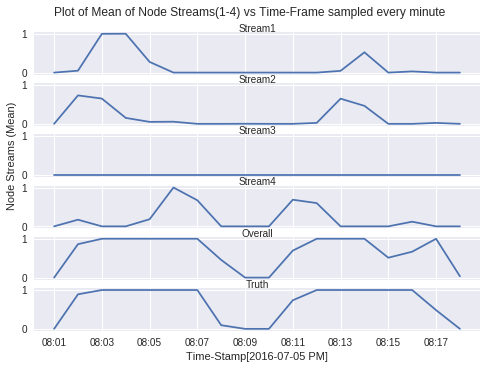

In [42]:
import datetime as dt
data_ts_1_mean = data_ts.resample('1min').mean() # Find the mean of the Node-Streams between the sampled time-intervals
fig, ax = plt.subplots(6, 1, sharex=True, sharey=True)
data_ts_1_mean.index= data_ts_1_mean.index.strftime("%I:%M")
for i,j in enumerate(data_ts.columns,1):
  #plt.subplot(6,1,i)
  df = data_ts_1_mean[j]
  ax[i-1].plot(df)
  ax[i-1].set_title(data_ts.columns[i-1], fontsize=10, pad=0.5)
  if i==3:
    ax[i-1].set(ylabel='Node Streams (Mean)')
  if i==6:
    ax[i-1].set(xlabel='Time-Stamp[2016-07-05 PM]')
#ax.xlabel('Time-Stamp (PM)')
for axi in ax.flat:
    axi.xaxis.set_major_locator(plt.MaxNLocator(10)) # Controls number of ticks at the axes. Here 10 is fine along the x-axis.
    #axi.yaxis.set_major_locator(plt.MaxNLocator(2))

caption="Plot of Mean of Node Streams(1-4) vs Time-Frame sampled every minute"
fig.text(.5, 0.92, caption, ha='center')

for axi in ax.flat:
    axi.xaxis.set_major_locator(plt.MaxNLocator(10))
    #axi.yaxis.set_major_locator(plt.MaxNLocator(2))

#### How would we go about finding the 'rough' path taken by the person?
1. Firstly, I mentioned 'rough' path, because, it makes sense to plot the data from all the 4 Nodes for every 1minute, instead of all the values as we just need some sort of skeleton of the movements of the person from 8:01-8:18pm. 
2. To find the 'rough' movement, I first sampled the data for every 1minute, and for the Node streams values that occur within that minute, I took a mean so that we can get a percentage where the person is with-respect-to all the Nodes. 
3. Below is the Dataframe containing the mean across the sampled 1minute data, and after that, I am going to plot a scatter-plot so that we can visulaize which Nodes 'light up' at each minute from 8:01-8:18pm, and at what percentage, so that we can estimate the path taken by the person.
4. Here, 'person' is just a relative term. It could be 2 different people, one present during some interval and leaving, and an other coming in in the next. The point of this is just to predict the path of a person using the Node data obtained.


In [43]:
data_ts_1_mean
data_mean = data_ts_1_mean[['Stream1','Stream2','Stream3','Stream4']]
#data_ts[data_ts['Stream3']==1]
data_ts_1_mean

,Stream1,Stream2,Stream3,Stream4,Overall,Truth
08:01,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
08:02,0.048980,0.732653,0.0,0.171429,0.861224,0.889796
08:03,0.997959,0.651020,0.0,0.000000,1.000000,1.000000
08:04,1.000000,0.153061,0.0,0.000000,1.000000,1.000000
08:05,0.274949,0.050916,0.0,0.183299,1.000000,1.000000
08:06,0.000000,0.055102,0.0,1.000000,1.000000,1.000000
08:07,0.000000,0.000000,0.0,0.671429,1.000000,1.000000
08:08,0.000000,0.000000,0.0,0.000000,0.455102,0.093878
08:09,0.000000,0.002041,0.0,0.000000,0.000000,0.000000
08:10,0.000000,0.000000,0.0,0.000000,0.000000,0.000000


### The Scatter-Plot of the Node-Streams at each time-interval sampled at 1 minute from 8:01pm - 8:18pm

Text(0.5, 1.0, 'Plot of Node Streams (Mean) occuring every minute')

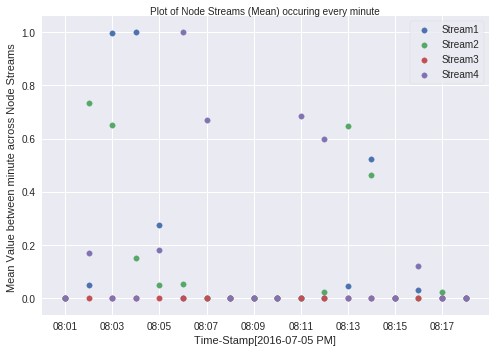

In [44]:
x = data_mean.index

fig, ax = plt.subplots()
ax.scatter(x, data_mean['Stream1'], s = 30)
ax.scatter(x, data_mean['Stream2'], s = 30)
ax.scatter(x, data_mean['Stream3'], s = 30)
ax.scatter(x, data_mean['Stream4'], s = 30)
ax.xaxis.set_major_locator(plt.MaxNLocator(10))

#ax.legend()
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, labels, loc='upper right', frameon=True)
ax.set(xlabel='Time-Stamp[2016-07-05 PM]')
ax.set(ylabel='Mean Value between minute across Node Streams ')
ax.set_title('Plot of Node Streams (Mean) occuring every minute', fontsize=10, pad=1)



### Just for more information, a Ranking-based table of the Average Path taken, based on the mean for every Node-Stream during each minute.

In [45]:
data_mini = data_ts_1_mean.iloc[:,:-2]
#print(data_mini)
data_mini = data_mini[data_mini>0]
ranked = data_mini.rank(1, ascending=False, method='first') # Rank the values in each row in descending order
ranked = ranked.fillna("Not Here") # Node-Streams that don't occur within that minute is flagged as 'Not here'
ranked


,Stream1,Stream2,Stream3,Stream4
08:01,Not Here,Not Here,Not Here,Not Here
08:02,3,1,Not Here,2
08:03,1,2,Not Here,Not Here
08:04,1,2,Not Here,Not Here
08:05,1,3,Not Here,2
08:06,Not Here,2,Not Here,1
08:07,Not Here,Not Here,Not Here,1
08:08,Not Here,Not Here,Not Here,Not Here
08:09,Not Here,1,Not Here,Not Here
08:10,Not Here,Not Here,Not Here,Not Here


### The above table thus shows the mean path travelled by the person every minute, and each time-instant is ranked by the amount he is present at that Node. Lower the rank, higher will be the person in-proximity around that Node.

# Conclusion

The following assumptions were made in the time-series data, and the tasks and results of ech assumption are given below:

## Assumption 1:
1) All Nodes work fine

2) There are no Blindspots
### Proposed Methology that closely should mimic 'Truth'
ORing consecutive Node Streams(1-4).
#### Logic:
If atleast 1 of the Nodes detected a person, then the Overall BlackBox should have an Output of 1.
### Results:
Correlation b/w the Proposed method and the Truth is 70.7% for 1minute sampled data, and 53% for 2minute sampled data
### Reason of low correlation and Inference:
1) We see that, there are time-intervals when all the Nodes do not detect anything, but the Truth says that there is a person.

2) The above situation cannot be solved by an algorithm because we need atleast one Node stream to detect the person, if the person is actually there.

3) This lead to the hypothesis that either a Node is faulty, or there exists a blind-spot where none of the Nodes can reach- which gives the motivation for the following below assumptions.

## Assumption 2:
1) Node 2(Stream3) is faulty

2) There are no Blindspots
### Proposed Methology that closely should mimic 'Truth'
ORing consecutive Node Streams(1-4).
#### Logic:
If atleast 1 of the Nodes detected a person, then the Overall BlackBox should have an Output of 1.
#### Task
The tasks under this assumption is more of an assurance that Node2 could be faulty.
The first reason which lead to concluding Node2 might be faulty was it's constant output of 0 even in the situations where all the nodes do output 0 when in-fact the Truth is 1. This points to something strange occuring with Node2 (provided of-course there are no blindspots).

To prove this, the intervals where the Truth says 1 when all Nodes output 0 are changed to 1 for Node2 (Stream3).
### Results:
Correlation b/w the Proposed method and the Truth is 99.9% for 1minute sampled data, and 99.9% for the original un-sampled data.
### Inference:
Again, the tasks employed in under this assumption was to just check if the Node2 were to detect something when all others didnt detect anything eventhough there is someone actually present, would the correlation be better than Assumption1 and would proposed algorithm perform as intended, which was true in both counts.

## Assumption 3:
1) All Nodes are fine

2) There is a Blindspot where none of the Nodes can reach.
### Proposed Methology that closely should mimic 'Truth'
ORing consecutive Node Streams(1-4).
#### Logic:
If atleast 1 of the Nodes detected a person, then the Overall BlackBox should have an Output of 1.
#### Task
The tasks to prove the hypothesis that there could be a blindspot and the approximate position of it are as follows:

1) First, the time-intervals where the Truth returns 1 despite all the Node return 0 are noted.

2) The time just before the above interval occurs and that just after the said interval occurs are collected and concatenated into a dataframe.

3) The resulting dataframe will have pairs of time-stamps where each pair consists of Before and After (the 'blindspotted' interval) Node stream values, and further simplifed to see in a particular time-stamp which Node Stream gets activated.  
##### Purpose?
The location of the person just before the interval and just after the interval will help to pinpoint where the person could be in the 'blindspotted interval'
### Results:

1)Upon inspection, it was concluded that the Blindspot exists at the center of the room due to reasons mentioned.

2)Correlation b/w the Proposed method and the Truth will be the same as that from Assumption2 as we are just creating a new column of Node which gives 1 during the blindspotted interval. So it will be 99.9% for 1minute sampled data, and 99.9% for the original un-sampled data, exactly the same.
### Inference:
The presence of the Blind-spot shows that, if we can intorduce a new Node at that position, we can capture the data which was overlooked by the other Nodes, and get a good result.

## Assumption 4:
I didn't do this, but it's important to state it here. Assumption3 can be modified in this way as well. Node2 is faulty, and removed completely, and the blindspot exists. But here, the blindspot  wouldn't necessarily be in center, as in the absence of Node2, it could be that the person would be closer to Node2, which would create a wider blindspot.

In conclusion, the Proposed algorithm seems very trivial as one would just require atleast 1 Node stream to detect something for the Overall Blackbox to give 1 as it's verdict, as there could be lot of false positives as well.
But for the task, this proved to do well and mimic the Truth column, which is the goal.

## Conjectures about the Black-Box algorithm
1) Since it does involve data streaming in real-time, so data analytics,wrangling,etc are probably done through SQL-based stream processors like Kafka.

2) The Final decision of True/False from a Node stream is made probably by also considering the temporal relationship of the data through maybe a sliding/moving average window.